<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/6_7_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Sentiment with an RNN from scratch

---

> **📊 IMDB Dataset**
>
> The **IMDB 50K Movie Reviews** dataset is a classic benchmark for **binary sentiment classification**. The Kaggle version provides a single CSV (`IMDB Dataset.csv`) with **50,000 reviews**, each labeled **positive** or **negative** in two columns: `review` and `sentiment`—handy for quick NLP experiments and deep-learning pipelines. ([Kaggle][1])
>
> This corpus mirrors the original **Large Movie Review Dataset** released by Maas et al., which consists of **25k training** and **25k test** reviews (balanced, highly polar), widely used to evaluate text classifiers; the Kaggle packaging simply consolidates the labeled examples into an easy-to-load format. ([Stanford AI Laboratory][2])
>
> [1]: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews "IMDB Dataset of 50K Movie Reviews"
>
> [2]: https://ai.stanford.edu/~amaas/data/sentiment/ "Large Movie Review Dataset"

---

## Overview

Here we'll build a *from-scratch* recurrent neural network (RNN) for **binary sentiment classification** on the IMDB reviews dataset. We'll cover three practical design choices:

1. Batching variable-length text via **padding**
2. **Handling padding inside the architecture** (not just in the dataloader)
3. **Controlling vocabulary size** with a max cap and mapping rare tokens to **`<UNK>`**—and why that rarely hurts performance

---

## Architectural Pattern (Karpathy's Diagram)

![RNN input–output patterns (Karpathy)](https://karpathy.github.io/assets/rnn/diags.jpeg)

**What this shows:** Typical RNN wiring patterns: *one-to-one*, *one-to-many*, *many-to-one*, and two forms of *many-to-many*.

**For IMDB sentiment we use the _many-to-one_ pattern:** a **sequence** of tokens $(w_1,\dots,w_L)$ maps to **one** label $y\in\{0,1\}$ (neg/pos). We process the whole review and use the **last valid hidden state** to predict sentiment.

$$
\hat{y}=\operatorname{softmax}(W_o\,h_L+b_o),\qquad
\mathcal L=\operatorname{CrossEntropyLoss}(\hat{y},\,y).
$$

---

## 1. Problem Setup & Basic Model

Each review is a token sequence with label $y\in\{0,1\}$. We embed tokens and feed them to a vanilla RNN:

$$
\begin{aligned}
x_t &= \mathrm{Embed}(w_t)\in\mathbb{R}^{E},\\
h_t &= \tanh\!\big(W_{ih}x_t + W_{hh}h_{t-1} + b\big),\quad h_0=\mathbf{0},\\
\text{logits} &= W_o h_{L} + b_o \in \mathbb{R}^{2},\\
\mathcal{L} &= \mathrm{CrossEntropyLoss}(\text{logits}, y).
\end{aligned}
$$

We care about the *last valid* hidden state $h_{L}$ for classification (the **many-to-one** case above).

---

## 2. Why We Need Padding (and Masks)

In a minibatch, reviews have different lengths $\{L_b\}_{b=1}^B$. GPUs want fixed shapes, so we **pad** each sequence to the batch max length $T=\max_b L_b$ with a special token `<PAD>` (index 0), yielding $X\in\mathbb{R}^{B\times T}$.

Padding creates **fake steps** beyond the true length. If we naively unroll over all $t=0,\dots,T-1$, short reviews keep updating on padding—polluting $h_t$.

### Masking Fix

For each time $t$:

$$
m_t[b]=\mathbf{1}\{t<L_b\}\in\{0,1\},\quad m_t\in\mathbb{R}^{B\times 1}.
$$

Update with broadcasted mask:

$$
\tilde h_t=\tanh(W_{ih}x_t+W_{hh}h_{t-1}+b),\qquad
h_t=m_t\odot\tilde h_t+(1-m_t)\odot h_{t-1}.
$$

Rows past their length keep their previous state.

### Code Sketch

```python
# x: (B, T, E), lengths: (B,)
h = x.new_zeros(B, H)
for t in range(T):
    x_t = x[:, t, :]                              # (B, E)
    m_t = (t < lengths).float().unsqueeze(1)      # (B, 1) → broadcasts over H
    h_cand = cell(x_t, h)                         # (B, H)
    h = m_t * h_cand + (1.0 - m_t) * h            # stop updates where padded
```

---

## 3. Maximum Vocabulary Size & `<UNK>` for Rare Tokens

Keeping *all* unique tokens inflates memory and invites overfitting to typos/IDs. Because token frequencies are Zipfian, a small head covers most occurrences. We therefore keep the top $K$ tokens (plus specials) and map the tail to `<UNK>`:

$$
\text{idx}(w)=
\begin{cases}
\text{word2idx}(w), & w\in\text{Top-}K,\\
\text{word2idx}(\texttt{<UNK>}), & \text{otherwise.}
\end{cases}
$$

### Why This Usually Doesn't Hurt

- **Coverage:** Top $K$ tokens cover >95% of usage; the tail is rare
- **Regularization:** Collapsing noisy rares to `<UNK>` reduces spurious memorization
- **Capacity:** Fewer embeddings focus learning on useful distributions
- **Context still helps:** Even if a rare word maps to `<UNK>`, surrounding tokens carry sentiment cues

**Special tokens used:** `<PAD>` (padding), `<BOS>`/`<EOS>` (optional boundaries), `<UNK>` (out-of-vocab)



In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
================================================================================
FROM-SCRATCH Recurrent Models: RNN (tanh),  LSTM — Toy + Full IMDB
Masking-based padding (no pack_padded_sequence), confusion matrices, gate peek
================================================================================

Pedagogical goals
-----------------
• Implement the *cells* and *sequence unrolling* manually (PyTorch autograd still
  handles derivatives, but we explicitly write the recurrence).
• Show how to *mask out padding* at each time step so padded tokens don't affect
  the state.
• Keep the same data pipeline (toy + IMDB fallback) and diagnostics you already use.
"""

from __future__ import annotations
import os, tarfile, urllib.request, random, re
from dataclasses import dataclass  # <— We'll explain @dataclass below.
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# Reproducibility + device
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True #EXPLAIN
    torch.backends.cudnn.benchmark = False #EXPLAIN

set_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# =============================================================================
# PART 2: IMDB — torchtext fallback-free (download original ACL IMDB)
# =============================================================================

class ListDataset(Dataset):
    def __init__(self, data: List[Tuple[str,int]]):
        self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

def _basic_clean(s: str) -> str:
    s = s.lower().replace('<br />', ' ')
    s = re.sub(r"[^a-z' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

from typing import List, Tuple, Optional
import os, random

def _read_imdb_dir(root: str, split: str, limit: Optional[int]) -> List[Tuple[str, int]]:
    """
    Read IMDB reviews from disk into a list of (text, label) pairs.

    Args:
        root:   Path to the dataset root that contains the 'aclImdb' folder.
        split:  Which split to read: typically 'train' or 'test'.
        limit:  Optional cap on total number of files to read (approx. balanced
                across classes). If None, read all files.

    Returns:
        List of (review_text, label) where label is 0 for 'neg' and 1 for 'pos'.
    """
    base = os.path.join(root, 'aclImdb', split)      # e.g., "<root>/aclImdb/train" or ".../test"
    pairs: List[Tuple[str,int]] = []                 # accumulator for (text, label) tuples

    # Iterate over the two sentiment classes with their numeric labels
    for label_name, y in [('neg', 0), ('pos', 1)]:
        folder = os.path.join(base, label_name)      # e.g., ".../train/neg" or ".../train/pos"
        files = sorted(os.listdir(folder))           # get file names (deterministic order via sort)

        if limit is not None:
            # If a total limit is requested, take roughly half from each class
            # (integer division ensures we don't exceed the total when summing both halves)
            files = files[:limit // 2]

        # Read each file's text and append with its label
        for fname in files:
            fpath = os.path.join(folder, fname)      # full path to review file
            # Open as UTF-8; 'errors=ignore' skips undecodable bytes instead of crashing
            with open(fpath, 'r', encoding='utf-8', errors='ignore') as f:
                txt = _basic_clean(f.read())         # normalize text (function defined above)
                pairs.append((txt, y))               # store (cleaned_text, numeric_label)

    random.shuffle(pairs)                             # in-place shuffle to mix pos/neg samples
    return pairs

def _download_acl_imdb(root: str = '/content', url: str = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'):
    os.makedirs(root, exist_ok=True)
    target_dir = os.path.join(root, 'aclImdb')
    if os.path.isdir(target_dir) and os.path.isdir(os.path.join(target_dir, 'train')):
        print(f"Found existing ACL IMDB at: {target_dir}")
        return target_dir
    archive_path = os.path.join(root, 'aclImdb_v1.tar.gz')
    if not os.path.isfile(archive_path):
        print("Downloading ACL IMDB (≈80MB)...")
        with urllib.request.urlopen(url) as resp, open(archive_path, 'wb') as out:
            out.write(resp.read())
    print("Extracting...")
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=root)
    print(f"Extracted to {target_dir}")
    return target_dir

def load_imdb(train_limit: Optional[int]=None, test_limit: Optional[int]=None):
    root = '/content' if os.path.isdir('/content') else os.getcwd()
    _download_acl_imdb(root=root)
    train_pairs = _read_imdb_dir(root, 'train', train_limit)
    test_pairs  = _read_imdb_dir(root, 'test',  test_limit)
    print(f"IMDB loaded via ACL fallback: train={len(train_pairs)}, test={len(test_pairs)}")
    return train_pairs, test_pairs

# =============================================================================
# PART 3: Vocab + collate (padding-aware with lengths)
# =============================================================================


class SimpleVocab:
    # Define special tokens as class attributes so they are accessible without instantiation
    PAD, UNK, BOS, EOS = "<PAD>", "<UNK>", "<BOS>", "<EOS>"

    def __init__(self, texts: List[str], max_vocab_size: int = 30000):
        """
        Build a word-level vocabulary from a list of raw texts.

        Args:
            texts: Corpus of strings to count token frequencies from.
            max_vocab_size: Upper bound on vocabulary size INCLUDING special tokens.
                            The final size will be min(max_vocab_size, num_unique_tokens+4).
        """
        counts: Dict[str, int] = {}                     # token -> frequency map
        for t in texts:                                 # iterate over documents
            for w in t.split():                         # naive tokenization: whitespace split
                counts[w] = counts.get(w, 0) + 1        # increment token frequency

        # Seed mapping with the 4 special tokens at fixed, known indices
        self.word2idx = {                               # string token -> integer id
            self.PAD: 0,                                # padding id (used by pad_sequence)
            self.UNK: 1,                                # out-of-vocabulary token id
            self.BOS: 2,                                # begin-of-sequence id
            self.EOS: 3,                                # end-of-sequence id
        }

        # Sort tokens (most common first)
        sorted_words = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)

        # Fill the vocabulary with the most frequent tokens up to the capacity
        # (reserve space already used by special tokens)
        for w, _ in sorted_words[:max_vocab_size - len(self.word2idx)]:
            if w not in self.word2idx:                  # (guard: should be true here)
                self.word2idx[w] = len(self.word2idx)   # assign next available integer id

        # Build inverse mapping for convenience (id -> token)
        self.idx2word = {i: w for w, i in self.word2idx.items()}

        # Cache the final size for quick access elsewhere
        self.vocab_size = len(self.word2idx)

    def encode(self, text: str, max_length: int = 300) -> torch.LongTensor:
        """
        Convert a raw string to a tensor of token ids with BOS/EOS and truncation.

        Args:
            text: Raw input string.
            max_length: Max total length INCLUDING BOS and EOS.
                        Effective payload length is max_length-2.

        Returns:
            1D LongTensor of token ids: [BOS, w1, w2, ..., wN, EOS]
        """
        toks = text.split()[:max_length - 2]            # keep room for BOS and EOS
        # Map tokens to ids, using UNK for OOV tokens; wrap with BOS/EOS
        ids = (
            [self.word2idx[self.BOS]] +
            [self.word2idx.get(w, self.word2idx[self.UNK]) for w in toks] +
            [self.word2idx[self.EOS]]
        )
        return torch.tensor(ids, dtype=torch.long)      # shape: (L,), L <= max_length


def collate_padded(batch, vocab: SimpleVocab, max_length: int = 300):
    """
    Collate function for DataLoader to:
      - encode strings to id tensors with BOS/EOS and truncation,
      - pad to the max length in the batch,
      - return lengths (before padding),
      - stack labels.

    Args:
        batch: List of (text, label) pairs from the dataset.
        vocab: SimpleVocab instance for encoding.
        max_length: Max total sequence length passed to vocab.encode.

    Returns:
        padded: LongTensor (B, T_max) of token ids padded with PAD.
        lens:   LongTensor (B,) lengths of each sequence BEFORE padding.
        y:      LongTensor (B,) class labels.
    """
    # Encode each text in the batch; ignore labels here
    ids = [vocab.encode(t, max_length) for t, _ in batch]  # list of 1D tensors, variable lengths

    # Compute true lengths (including BOS/EOS, excluding padding)
    lens = torch.tensor([len(x) for x in ids], dtype=torch.long)

    # Left-align sequences and right-pad with PAD to the maximum length in this batch
    padded = torch.nn.utils.rnn.pad_sequence(
        ids,
        batch_first=True,                                   # output shape (B, T_max)
        padding_value=vocab.word2idx[SimpleVocab.PAD]       # numeric id used for padding
    )

    # Stack labels in the same batch order
    y = torch.tensor([y for _, y in batch], dtype=torch.long)

    return padded, lens, y



def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t,p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def plot_confusion_matrix(cm, class_names=("neg","pos"), title="Confusion Matrix"):
    cm = cm.astype(np.float64)
    row_sums = cm.sum(axis=1, keepdims=True) + 1e-12
    cm_norm = cm / row_sums * 100.0
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm_norm, aspect='equal')
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]:.1f}%)", ha='center', va='center')
    plt.tight_layout(); plt.show()

def plot_histories(histories: Dict[str, Dict[str, List[float]]]):
    # Loss
    plt.figure(figsize=(6,4))
    for name,h in histories.items():
        plt.plot(h['train_loss'], label=f'{name} Train')
        plt.plot(h['test_loss'],  linestyle='--', label=f'{name} Test')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()
    # Accuracy
    plt.figure(figsize=(6,4))
    for name,h in histories.items():
        plt.plot(h['train_acc'], label=f'{name} Train')
        plt.plot(h['test_acc'],  linestyle='--', label=f'{name} Test')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy vs Epoch'); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()
    # Grad norm
    plt.figure(figsize=(6,4))
    for name,h in histories.items():
        plt.plot(h['grad_norm'], label=name)
    plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Avg grad norm (log)'); plt.title('Gradient Norm')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


Device: cpu


### Quick Intro: `@dataclass` Decorator

The `@dataclass` decorator auto-generates boilerplate methods for classes that primarily hold data.

**What it creates automatically:**
- **`__init__(...)`** – Constructor that accepts and assigns all fields
- **`__repr__()`** – Clean string representation for debugging
- **`__eq__(...)`** – Equality comparison by comparing all attributes

**Compare the two approaches:**

```python
# ✅ With @dataclass (clean & concise)
from dataclasses import dataclass

@dataclass
class ToyConfig:
    n_train: int = 1200
    n_test: int = 300
    min_len: int = 8
    max_len: int = 30
    pos_weight: float = 0.55
    neg_weight: float = 0.55
    noise_label: float = 0.05
    oov_rate: float = 0.05
```

```python
# ❌ Without @dataclass (verbose boilerplate)
class ToyConfig:
    def __init__(self, n_train: int = 1200, n_test: int = 300,
                 min_len: int = 8, max_len: int = 30,
                 pos_weight: float = 0.55, neg_weight: float = 0.55,
                 noise_label: float = 0.05, oov_rate: float = 0.05):
        self.n_train = n_train
        self.n_test = n_test
        # ... repeat for all 8 fields

    def __repr__(self):
        return f"ToyConfig(n_train={self.n_train}, n_test={self.n_test}, ...)"
    
    def __eq__(self, other):
        if not isinstance(other, ToyConfig):
            return NotImplemented
        return (self.n_train == other.n_train and
                self.n_test == other.n_test and ...)
```

**Usage:**

```python
config1 = ToyConfig()                              # Use defaults
config2 = ToyConfig(n_train=2000, n_test=500)     # Override some values

print(config1)        # ToyConfig(n_train=1200, n_test=300, ...)
print(config1 == config2)  # False (auto-comparison works!)
```

**Why use it?** Concise, readable, less error-prone, and built-in comparison support.

# RNN from scratch


## Combining weights in the RNN cell
In the lecture we combined the weights in a single, larger linear layer that processes the concatenated input and previous hidden state. Mathematically, it's the same operation as keeping $W_{ih}$ and $W_{hh}$, but it can be faster on GPU.
However, it's more complex if you want to apply different initialization schemes to the input-to-hidden and hidden-to-hidden weights (later for LSTM we have less concern on weight initialization). [Image from Colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)



![Simple RNN cell](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

In [ ]:
import torch
import torch.nn as nn
from typing import Optional

# -----------------------------------------------------------------------------
# Shape conventions used throughout:
#   B = batch size, T = time steps, E = embed dim, H = hidden dim
# -----------------------------------------------------------------------------

class VanillaRNNCell(nn.Module):
    """
    A single vanilla RNN cell with tanh nonlinearity.

    Math:
        h_t = tanh(W_ih x_t + W_hh h_{t-1} + b)

    Note on gradients:
      In BPTT, repeated multiplications by tanh'(·) ∈ (0, 1] can shrink
      gradients (vanishing gradients) for long sequences.
    """
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        # Input → hidden affine (includes bias b  ∈ ℝ^H)
        self.W_ih = nn.Linear(input_size, hidden_size)
        # Hidden → hidden affine (no bias, classic RNN parametrization)
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=False)

        # Recommended initializations for stability with tanh RNNs:
        nn.init.xavier_uniform_(self.W_ih.weight)  # keeps forward variance roughly constant
        nn.init.orthogonal_(self.W_hh.weight)      # preserves norm across time steps
        nn.init.zeros_(self.W_ih.bias)             # start with no bias offset

    def forward(self, x_t: torch.Tensor, h_prev: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x_t   : (B, E)   features at time t
            h_prev: (B, H)   previous hidden state
        Returns:
            h_t   : (B, H)   new hidden state
        """
        # Affine transforms + elementwise tanh activation
        return torch.tanh(self.W_ih(x_t) + self.W_hh(h_prev))


class RNNSequence(nn.Module):
    """
    Unroll any compatible RNN cell (e.g., VanillaRNNCell, ReLURNNCell) across a
    batch of **padded** sequences, using a mask so padded time steps do not
    update the hidden state.

    Inputs:
      x       : (B, T, E) embedded tokens
      lengths : (B,)       true (unpadded) lengths per sequence
      return_all: if True, also return all hidden states (B, T, H)

    Returns:
      h_T     : (B, H)     last valid hidden per sequence
      H_all   : (B, T, H) or None
    """
    def __init__(self, cell: nn.Module):
        super().__init__()
        self.cell = cell  # must implement forward(x_t, h_prev) -> h_t

    def forward(self, x: torch.Tensor, lengths: torch.Tensor, return_all: bool=False):
        B, T, E = x.size()

        # Infer hidden size H from the cell (supports multiple cell types)
        H = self.cell.W_ih.out_features if hasattr(self.cell, 'W_ih') else self.cell.hidden_size

        # Initialize hidden state on the same device/dtype as x
        h = x.new_zeros(B, H)

        # Optionally collect hidden states for visualization/analysis
        h_all = []

        # Time unroll with per-time-step mask
        for t in range(T):
            x_t = x[:, t, :]  # (B, E)

            # mask_t: (B,1) with 1 for "valid (t < length)" and 0 for "padded"
            # The singleton dim ensures broadcasting over hidden dim H.
            mask_t = (t < lengths).float().unsqueeze(1)  # (B, 1)

            # Compute candidate next hidden
            if isinstance(self.cell, (VanillaRNNCell,)):  # add ReLURNNCell if defined elsewhere
                h_candidate = self.cell(x_t, h)           # (B, H)
                # Keep h_candidate where valid; keep previous h where padded
                h = mask_t * h_candidate + (1.0 - mask_t) * h
            else:
                raise RuntimeError("RNNSequence expects a cell like VanillaRNNCell (or ReLURNNCell).")

            if return_all:
                h_all.append(h.unsqueeze(1))  # (B,1,H) → will cat to (B,T,H)

        if return_all:
            return h, torch.cat(h_all, dim=1)
        return h, None


class FromScratchRNN(nn.Module):
    """
    End-to-end text classifier:
      tokens → embeddings → masked RNN unroll → last hidden → linear → logits(2)

    Notes:
      - Embedding uses padding_idx=0 so the PAD row is ignored in gradient updates.
      - The final Linear outputs **two logits** (neg/pos); use CrossEntropyLoss
        with integer targets y ∈ {0,1}. (Do NOT apply softmax before CE.)
    """
    def __init__(self, vocab_size: int, embed_dim: int, hidden: int, cell_type: str = 'tanh'):
        super().__init__()

        # Token embedding table; index 0 reserved for <PAD>
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Choose recurrence cell
        if cell_type == 'tanh':
            cell = VanillaRNNCell(embed_dim, hidden)
        elif cell_type == 'relu':
            # Assumed defined elsewhere with the same interface as VanillaRNNCell
            cell = ReLURNNCell(embed_dim, hidden)  # type: ignore[name-defined]
        else:
            raise ValueError("cell_type must be 'tanh' or 'relu'")

        # Padded unroll wrapper
        self.sequence = RNNSequence(cell)

        # Classifier head to 2 classes (binary sentiment)
        self.fc = nn.Linear(hidden, 2)

        # Mildly randomize embeddings; force PAD row to exact zeros
        with torch.no_grad():
            nn.init.normal_(self.embedding.weight, mean=0.0, std=0.1)
            if self.embedding.padding_idx is not None:
                self.embedding.weight[self.embedding.padding_idx].zero_()

    def forward(self, X: torch.Tensor, lengths: torch.Tensor):
        """
        Args:
            X       : (B, T)   token ids (padded)
            lengths : (B,)     true lengths (before padding)
        Returns:
            logits  : (B, 2)   class scores (for CrossEntropyLoss)
            emb     : (B, T, E) embeddings (returned for optional analysis/viz)
        """
        emb = self.embedding(X)               # (B, T, E)
        h_T, _ = self.sequence(emb, lengths)  # (B, H) last **valid** hidden per sequence
        logits = self.fc(h_T)                 # (B, 2)
        return logits, emb




![LSTM chain](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

**Clarifying the LSTM "$z\in\mathbb{R}^{4H}$"**

We concatenate $[x_t;h_{t-1}]\in\mathbb{R}^{E+H}$ and apply *one* linear:

$$
z=W[x_t;h_{t-1}]+b\in\mathbb{R}^{4H}.
$$

This single vector is then **split** into four contiguous $H$-length blocks:

$$
z=\big[z_f;\,z_i;\,z_o;\,z_g\big],\quad z_\star\in\mathbb{R}^{H}.
$$

They feed the gates/candidate:

$$
f_t=\sigma(z_f),\; i_t=\sigma(z_i),\; o_t=\sigma(z_o),\; g_t=\tanh(z_g),\;
c_t=f_t\odot c_{t-1}+i_t\odot g_t,\; h_t=o_t\odot\tanh(c_t).
$$

Fusing the four affines into one is purely an **efficiency trick**; it's equivalent to using four separate matrices.

Found existing ACL IMDB at: /content/aclImdb
IMDB loaded via ACL fallback: train=25000, test=25000
Vocab size: 30000

=== Training RNN (tanh) — scratch ===
Epoch 01/3 | Train L=0.5560 A=72.4% | Test L=0.4562 A=80.8% | Grad∥·∥=4.754
Epoch 02/3 | Train L=0.3909 A=84.2% | Test L=0.4646 A=79.2% | Grad∥·∥=7.014
Epoch 03/3 | Train L=0.2938 A=88.6% | Test L=0.4625 A=82.0% | Grad∥·∥=5.360

=== Training LSTM — scratch ===
Epoch 01/3 | Train L=0.4566 A=78.2% | Test L=0.3968 A=83.1% | Grad∥·∥=3.014
Epoch 02/3 | Train L=0.2489 A=90.5% | Test L=0.4172 A=83.6% | Grad∥·∥=3.174
Epoch 03/3 | Train L=0.1545 A=94.6% | Test L=0.3931 A=84.6% | Grad∥·∥=3.133

Plotting histories...


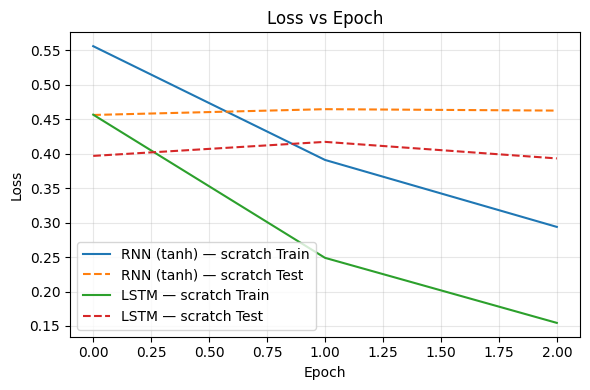

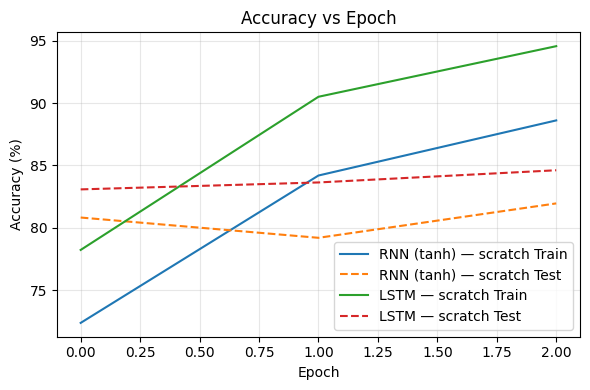

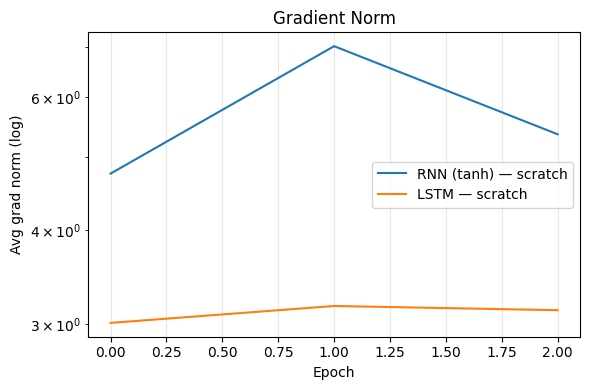


=== Confusion Matrices (normalized) ===


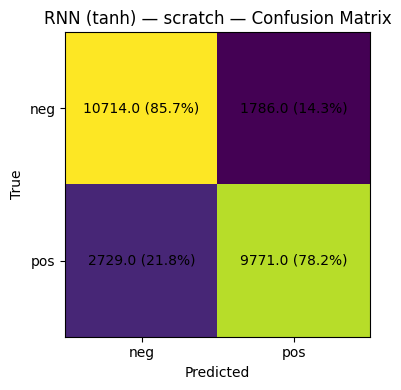

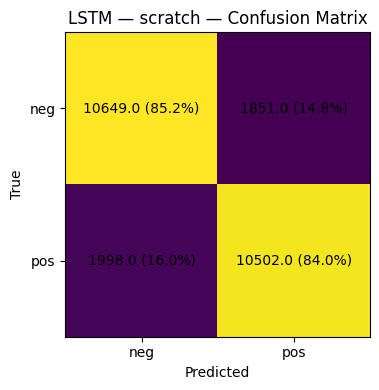


Peeking gates on: amazing wonderful perfect movie but some scene boring


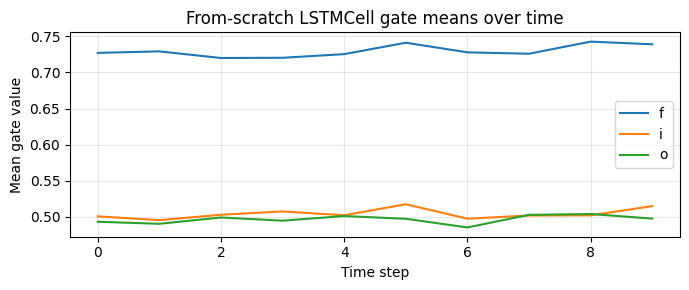

In [ ]:
import torch
import torch.nn as nn
from dataclasses import dataclass
# Assumes: numpy as np, matplotlib.pyplot as plt, torch.nn.functional as F,
# torch.optim as optim, DEVICE, SimpleVocab are defined elsewhere (same as RNN part).

# =============================================================================
# PART 4: FROM-SCRATCH CELLS + SEQUENCE MODULES
# =============================================================================

class LSTMCell(nn.Module):
    """
    A minimal LSTM cell (no peepholes, no proj). Compared to the vanilla RNN,
    LSTM keeps a *separate memory* c_t with an additive update, which is the
    key to long-range credit assignment.

    Notation (σ = sigmoid, ⊙ = elementwise):
        z = W [x_t; h_{t-1}] + b   with z ∈ ℝ^{4H}
        split z → (z_f, z_i, z_o, z_g), each ∈ ℝ^{H}
        f_t = σ(z_f), i_t = σ(z_i), o_t = σ(z_o), g_t = tanh(z_g)
        c_t = f_t ⊙ c_{t-1} + i_t ⊙ g_t
        h_t = o_t ⊙ tanh(c_t)
    """
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size

        # One fused affine for all gates is faster than 4 separate linears:
        #   W ∈ ℝ^{4H × (E+H)}, b ∈ ℝ^{4H}
        self.W = nn.Linear(input_size + hidden_size, 4 * hidden_size)

        # Good practice for LSTM init:
        # - xavier for W      : keeps variance reasonable
        # - forget bias to +1 : encourages c_t to *remember* at the start
        with torch.no_grad():
            nn.init.xavier_uniform_(self.W.weight)
            nn.init.zeros_(self.W.bias)
            b = self.W.bias.view(4, hidden_size)  # reshape to (4, H) to address a gate row
            b[0].fill_(1.0)                       # gate order: [f, i, o, g] → set f_t bias = +1

    def forward(self, x_t: torch.Tensor, h_prev: torch.Tensor, c_prev: torch.Tensor):
        """
        Args:
            x_t   : (B, E) current input
            h_prev: (B, H) previous hidden
            c_prev: (B, H) previous cell (memory)
        Returns:
            h_t   : (B, H) new hidden
            c_t   : (B, H) new cell
            (f,i,o,g): tuple of gate activations (each (B, H)) for introspection
        """
        # Single affine on concatenated [x_t ; h_prev]  →  z ∈ ℝ^{4H}
        z = self.W(torch.cat([x_t, h_prev], dim=-1))

        # Gate chunking: contiguous H-sized slices; avoids extra allocations
        H = self.hidden_size
        f = torch.sigmoid(z[..., 0*H:1*H])  # forget   gate ∈ (0,1)
        i = torch.sigmoid(z[..., 1*H:2*H])  # input    gate ∈ (0,1)
        o = torch.sigmoid(z[..., 2*H:3*H])  # output   gate ∈ (0,1)
        g = torch.tanh(   z[..., 3*H:4*H])  # candidate      ∈ (-1,1)

        # Additive path (the “gradient highway”):
        c_t = f * c_prev + i * g            # keep (f⋅c_prev) + write (i⋅g)
        h_t = o * torch.tanh(c_t)           # expose memory via output gate

        return h_t, c_t, (f, i, o, g)


class LSTMSequence(nn.Module):
    """
    Unrolls LSTMCell across time with *the same masking idea as in the RNN*.
    We mask both h and c so padded steps do not evolve state.

    Inputs:
      x       : (B, T, E)
      lengths : (B,)
      return_all: if True → also returns per-step h and c for analysis/viz

    Returns:
      h_T     : (B, H)
      all_h   : (B, T, H) or None
      all_c   : (B, T, H) or None
    """
    def __init__(self, cell: LSTMCell):
        super().__init__()
        self.cell = cell

    def forward(self, x: torch.Tensor, lengths: torch.Tensor, return_all: bool=False):
        B, T, E = x.size()
        H = self.cell.hidden_size

        # Init states on the fly to match device/dtype of x
        h = x.new_zeros(B, H)
        c = x.new_zeros(B, H)

        h_all, c_all = [], []

        for t in range(T):
            x_t = x[:, t, :]                              # (B, E)
            mask_t = (t < lengths).float().unsqueeze(1)   # (B, 1), broadcasts over H

            # Cell step (same interface as PyTorch's nn.LSTMCell)
            h_cand, c_cand, _ = self.cell(x_t, h, c)

            # Apply mask to BOTH hidden and cell states
            h = mask_t * h_cand + (1.0 - mask_t) * h
            c = mask_t * c_cand + (1.0 - mask_t) * c

            if return_all:
                h_all.append(h.unsqueeze(1))  # (B,1,H)
                c_all.append(c.unsqueeze(1))  # (B,1,H)

        if return_all:
            return h, torch.cat(h_all, dim=1), torch.cat(c_all, dim=1)
        return h, None, None


# =============================================================================
# PART 5: End-to-end models (embedding → recurrent unroll → classifier)
# =============================================================================

class FromScratchLSTM(nn.Module):
    """
    Same wrapper pattern as the RNN version:
      tokens → embedding → LSTMSequence → last hidden → Linear(2) → logits
    """
    def __init__(self, vocab_size: int, embed_dim: int, hidden: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.sequence  = LSTMSequence(LSTMCell(embed_dim, hidden))
        self.fc        = nn.Linear(hidden, 2)  # 2 logits for CE w/ labels ∈ {0,1}

        # Lightweight embedding init; freeze PAD row at zeros (same rationale as RNN)
        with torch.no_grad():
            nn.init.normal_(self.embedding.weight, mean=0.0, std=0.1)
            if self.embedding.padding_idx is not None:
                self.embedding.weight[self.embedding.padding_idx].zero_()

    def forward(self, X: torch.Tensor, lengths: torch.Tensor):
        emb   = self.embedding(X)                 # (B, T, E)
        h_T, _, _ = self.sequence(emb, lengths)   # (B, H) last *valid* hidden
        logits = self.fc(h_T)                     # (B, 2)
        return logits, emb


# =============================================================================
# PART 6: Training (identical loop structure to the RNN version)
# =============================================================================

@dataclass
class TrainConfig:
    epochs: int = 3
    lr: float = 2e-3
    batch_size: int = 128
    clip: float = 5.0          # clip global grad-norm → stabilizes gated nets too

def accuracy(logits, y):
    # Metric only (non-differentiable): argmax over 2 logits vs. integer labels
    return (logits.argmax(dim=1) == y).float().mean().item() * 100.0

def train(model, train_dl, test_dl, cfg: TrainConfig):
    # Adam is a robust default for LSTMs; CE matches our 2-logit head.
    opt = optim.Adam(model.parameters(), lr=cfg.lr)

    hist = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'grad_norm':[]}
    for ep in range(1, cfg.epochs+1):
        model.train()
        losses, accs, gradnorms = [], [], []

        for X, lengths, y in train_dl:
            X, lengths, y = X.to(DEVICE), lengths.to(DEVICE), y.to(DEVICE)

            logits, _ = model(X, lengths)
            loss = F.cross_entropy(logits, y)     # softmax-CE over 2 classes

            opt.zero_grad()
            loss.backward()

            # Track total grad-norm (∥∇θ∥₂) before clipping for diagnostics
            total = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total += p.grad.data.norm(2).item()
            gradnorms.append(total)

            # Clip to avoid exploding gradients (can still occur with LSTMs)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip)
            opt.step()

            losses.append(loss.item())
            accs.append(accuracy(logits, y))

        # ---------- evaluation (no grad) ----------
        model.eval()
        with torch.no_grad():
            tlosses, taccs = [], []
            for X, lengths, y in test_dl:
                X, lengths, y = X.to(DEVICE), lengths.to(DEVICE), y.to(DEVICE)
                logits, _ = model(X, lengths)
                tlosses.append(F.cross_entropy(logits, y).item())
                taccs.append(accuracy(logits, y))

        # Log epoch stats
        hist['train_loss'].append(np.mean(losses))
        hist['train_acc'].append(np.mean(accs))
        hist['test_loss'].append(np.mean(tlosses))
        hist['test_acc'].append(np.mean(taccs))
        hist['grad_norm'].append(np.mean(gradnorms))

        print(f"Epoch {ep:02d}/{cfg.epochs} | "
              f"Train L={hist['train_loss'][-1]:.4f} A={hist['train_acc'][-1]:.1f}% | "
              f"Test L={hist['test_loss'][-1]:.4f} A={hist['test_acc'][-1]:.1f}% | "
              f"Grad∥·∥={hist['grad_norm'][-1]:.3f}")

    return hist


def collect_predictions(model, dl):
    """
    Utility for confusion matrices etc. (same pattern as RNN).
    Returns stacked numpy arrays of true and predicted labels.
    """
    model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for X, lengths, y in dl:
            X, lengths = X.to(DEVICE), lengths.to(DEVICE)
            logits, _ = model(X, lengths)
            yh.append(logits.argmax(1).cpu().numpy())
            ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(yh)


# =============================================================================
# PART 7: LSTM gate peek using our own LSTMCell (device-safe)
# =============================================================================

def peek_lstm_gates_on_sentence(vocab: SimpleVocab, sentence: str, embed: nn.Embedding, hidden_size=16):
    """
    Educational probe:
      - Runs our LSTMCell on a single sentence.
      - Records mean gate activations (f, i, o) over time.
      - Useful to illustrate gating dynamics (e.g., f_t near 1.0 → remember).

    Notes:
      - This uses the *standalone* cell, not the trained model’s weights.
      - For inspecting a trained LSTM, replace 'cell' with your model's cell and
        feed the same embedding table, or capture gates inside the training forward.
    """
    ids = vocab.encode(sentence, max_length=300)
    ids = ids[ids != vocab.word2idx[SimpleVocab.PAD]]   # drop padding if any (safety)

    device = embed.weight.device
    x = embed(ids.to(device).unsqueeze(0)).squeeze(0).detach()  # (T, E)

    cell = LSTMCell(x.size(1), hidden_size).to(device)          # fresh probe cell
    H = hidden_size
    h = torch.zeros(H, device=device)
    c = torch.zeros(H, device=device)

    means = {'f': [], 'i': [], 'o': []}
    for t in range(x.size(0)):
        h, c, (f, i, o, g) = cell(x[t], h, c)
        # Record per-step averages to avoid clutter (you can plot per-dim too)
        means['f'].append(f.mean().item())
        means['i'].append(i.mean().item())
        means['o'].append(o.mean().item())

    # Quick plot (inline); replace with your preferred viz tooling as needed
    import matplotlib.pyplot as plt
    T = x.size(0)
    fig, ax = plt.subplots(figsize=(7, 3))
    for k in ['f', 'i', 'o']:
        ax.plot(range(T), means[k], label=k)
    ax.set_xlabel("Time step"); ax.set_ylabel("Mean gate value")
    ax.set_title("From-scratch LSTMCell gate means over time")
    ax.legend(); ax.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# =============================================================================
# PART 8: Main driver
# =============================================================================

def tiny_demo_train(use_imdb: bool=False, train_limit: Optional[int]=None, test_limit: Optional[int]=None,
                    epochs:int=3, embed_dim:int=64, hidden:int=64, clip:float=5.0, lr:float=2e-3):
    """
    use_imdb=False → toy (fast). use_imdb=True → full IMDB (downloaded once).

    Parameters:
      epochs, embed_dim, hidden, clip, lr : training & model knobs.
    """
    if use_imdb:
        train_pairs, test_pairs = load_imdb(train_limit, test_limit)
        all_texts = [t for t,_ in train_pairs + test_pairs]
        vocab = SimpleVocab(all_texts, max_vocab_size=30000)
        collate = lambda batch: collate_padded(batch, vocab=vocab, max_length=300)
        train_dl = DataLoader(ListDataset(train_pairs), batch_size=128, shuffle=True,  collate_fn=collate)
        test_dl  = DataLoader(ListDataset(test_pairs),  batch_size=256, shuffle=False, collate_fn=collate)
    else:
        toy = ToyConfig()
        train_ds, test_ds = ToySentiment('train', toy), ToySentiment('test', toy)
        all_texts = [t for t,_ in train_ds.data + test_ds.data]
        vocab = SimpleVocab(all_texts, max_vocab_size=5000)
        collate = lambda batch: collate_padded(batch, vocab=vocab, max_length=60)
        train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  collate_fn=collate)
        test_dl  = DataLoader(test_ds,  batch_size=128, shuffle=False, collate_fn=collate)

    print(f"Vocab size: {vocab.vocab_size}")

    models = {
        "RNN (tanh) — scratch": FromScratchRNN(vocab.vocab_size, embed_dim, hidden, cell_type='tanh').to(DEVICE),
        "LSTM — scratch":       FromScratchLSTM(vocab.vocab_size, embed_dim, hidden).to(DEVICE),
    }

    histories = {}
    cfg = TrainConfig(epochs=epochs, lr=lr, batch_size=128, clip=clip)
    for name, m in models.items():
        print(f"\n=== Training {name} ===")
        histories[name] = train(m, train_dl, test_dl, cfg)

    print("\nPlotting histories...")
    plot_histories(histories)

    print("\n=== Confusion Matrices (normalized) ===")
    for name, m in models.items():
        y_true, y_pred = collect_predictions(m, test_dl)
        cm = confusion_matrix(y_true, y_pred, num_classes=2)
        plot_confusion_matrix(cm, class_names=("neg","pos"), title=f"{name} — Confusion Matrix")

    sample = "amazing wonderful perfect movie but some scene boring"
    print("\nPeeking gates on:", sample)
    lstm = models["LSTM — scratch"]
    peek_lstm_gates_on_sentence(vocab, sample, lstm.embedding, hidden_size=16)

if __name__ == "__main__":
    # Example full IMDB run (takes time on Colab, but works):
    tiny_demo_train(use_imdb=True, train_limit=None, test_limit=None, epochs=3)
    # tiny_demo_train(use_imdb=False, epochs=3)
